Lets create a monte carlo pricing of an option on 2 underlying correlated stocks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
from time import time
%matplotlib inline

In [2]:
# Parameters
S0 = 100.;
B0 = 100.0
K = 105.; # call option strike
T = 1.0; # expiry
r = 0.05; # risk-free rate
M = 50; # number of steps
dt = T/M; #period of each step
I = 250000 # number of trials

In [12]:
# two stock S and B which are correlated with rho
B_sigma = 0.2
S_sigma = 0.3
rho =0.99

# calculate their cholesky matrix from their correlation matrix
corr_mat = np.zeros((2, 2))
corr_mat[0,:] = [1.0, rho]
corr_mat[1,:] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)

cho_mat

array([[ 1.        ,  0.        ],
       [ 0.99      ,  0.14106736]])

In [13]:
np.random.seed(20000)
ran_num = np.random.standard_normal((2, M+1, I))

# simulate correlated path of underlyers
B = np.zeros_like(ran_num[0])
S = np.zeros_like(B)
B[0] = B0
S[0] = S0
for t in range(1, M + 1):
    # generate correlated random variables for each step
    ran = np.dot(cho_mat, ran_num[:,t,:])
    B[t] = B[t-1] * np.exp((r-0.5*B_sigma**2)*dt + B_sigma * np.sqrt(dt) * ran[0])    
    S[t] = S[t-1] * np.exp((r-0.5*S_sigma**2)*dt + S_sigma * np.sqrt(dt) * ran[1])

In [14]:
# create payoff which takes the best of the two stock
hT = np.maximum(S[-1]-K, np.maximum(B[-1]-K, 0))

In [15]:
C0 = np.exp(-r*T)*np.sum(hT)/I

In [16]:
C0

12.215273985119852

In [26]:
# lets plot the option price as a function of the correlation between the 2 underlyers
rhos = np.linspace(-0.99, 0.99, 20)
C = []
#C = np.zeros_like(rhos)
for rho in rhos:
    corr_mat = np.zeros((2, 2))
    corr_mat[0,:] = [1.0, rho]
    corr_mat[1,:] = [rho, 1.0]
    cho_mat = np.linalg.cholesky(corr_mat)
    
    ran_num = np.random.standard_normal((2, M+1, I))
    
    B = np.zeros_like(ran_num[0])
    S = np.zeros_like(B)
    B[0] = B0
    S[0] = S0
    for t in range(1, M + 1):
        # generate correlated random variables for each step
        ran = np.dot(cho_mat, ran_num[:,t,:])
        B[t] = B[t-1] * np.exp((r-0.5*B_sigma**2)*dt + B_sigma * np.sqrt(dt) * ran[0])    
        S[t] = S[t-1] * np.exp((r-0.5*S_sigma**2)*dt + S_sigma * np.sqrt(dt) * ran[1])
        
    hT = np.maximum(S[-1]-K, np.maximum(B[-1]-K, 0))
    
    C.append(np.exp(-r*T)*np.sum(hT)/I)
        

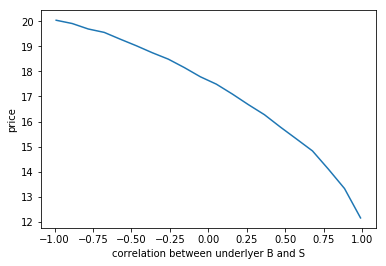

In [29]:
plt.plot(rhos, C)
plt.xlabel('correlation between underlyer B and S')
plt.ylabel('price')